In [6]:
import os
import pandas as pd
import json
import re

In [7]:
# Forms a logger data frame
def form_logger_df(power_data_logger_file: os.path):
    logger_df = pd.read_csv(power_data_logger_file, sep=r'\s+')
    logger_df = logger_df[['timestamp', 'voltage_V', 'current_A', 'temp_C_ema']]

    # Ensure proper data types
    logger_df['timestamp'] = logger_df['timestamp'].astype(float)
    logger_df['voltage_V'] = logger_df['voltage_V'].astype(float)
    logger_df['current_A'] = logger_df['current_A'].astype(float)
    logger_df['temp_C_ema'] = logger_df['temp_C_ema'].astype(float)

    return logger_df

In [8]:
logger_df = form_logger_df('data_logger.txt')

In [9]:
logger_df.head()

,timestamp,voltage_V,current_A,temp_C_ema
0,1.729795e+09,5.13603,0.72889,29.3
1,1.729795e+09,5.13603,0.71304,29.3
2,1.729795e+09,5.13603,0.72889,29.3
3,1.729795e+09,5.13603,0.72889,29.3
4,1.729795e+09,5.13603,0.72889,29.3


In [10]:
# To form a command data frame with parsed output, updated end_time, and model column
def form_command_df(command_feedback_file: os.path):
    # List to store each command as a dictionary
    command_list = []

    # Regular expression to match the pattern of each image result in the output
    output_pattern = re.compile(
        r"Image: (?P<image_file>[^,]+), "
        r"Resolution: (?P<resolution_width>\d+)x(?P<resolution_height>\d+), "
        r"Framework: (?P<framework>[A-Z]+), "
        r"Set FPS: (?P<fps>[\d.]+), "
        r"Inference time: (?P<inference_time>[\d.]+) seconds, "
        r"Predicted class: (?P<predicted_class>\d+)"
    )
    
    # Regular expression to extract the model name from the command
    model_pattern = re.compile(r'run_model\.py\s+([^\s]+)')

    # Open the file and read line by line
    with open(command_feedback_file, 'r') as file:
        for line in file:
            # Parse each line as a JSON object
            command_data = json.loads(line.strip())
            
            # Extract the output field and find all matches for the image data
            output_data = command_data.get('output', '')
            matches = output_pattern.findall(output_data)
            
            # Extract the model name from the command
            model_match = model_pattern.search(command_data['command'])
            model_name = model_match.group(1) if model_match else None
            
            # For each match, create a new dictionary entry with the parsed fields
            for match in matches:
                # Calculate the updated end_time based on the formula
                fps = float(match[4])
                inference_time = float(match[5])
                start_time = float(command_data["start_time"])
                # Compute max(1/fps, inference_time)
                time_delta = max(1/fps, inference_time)
                # Calculate new end_time
                new_end_time = start_time + time_delta

                image_data = {
                    "client_id": command_data["client_id"],
                    "command": command_data["command"],
                    "model": model_name,  # Add the model name to the dictionary
                    "start_time": float(command_data["start_time"]),
                    "new_end_time": round(new_end_time, 3),  # Rounded to 3 decimal places (10ms precision)
                    "error": command_data["error"],
                    "image_file": match[0],
                    "resolution_width": int(match[1]),
                    "resolution_height": int(match[2]),
                    "framework": match[3],
                    "fps": fps,
                    "inference_time": inference_time,
                    "predicted_class": int(match[6])
                }
                # Append the image data to the command list
                command_list.append(image_data)
    
    # Convert the list of image data into a pandas DataFrame
    command_df = pd.DataFrame(command_list)

    # Optionally format the float display in the DataFrame with three decimal places
    pd.options.display.float_format = '{:.3f}'.format

    return command_df

In [11]:
command_df = form_command_df("command_feedback.txt")

In [12]:
command_df.head()

,client_id,command,model,start_time,new_end_time,error,image_file,resolution_width,resolution_height,framework,fps,inference_time,predicted_class
0,client1,python run_model.py RESNET50 0.100 ./images,RESNET50,1729794818.597,1729794828.597,/home/pi/epc/venv/lib/python3.11/site-packages...,cat_0.jpg,481,640,PYTORCH,0.100,0.595,898
1,client1,python run_model.py RESNET50 0.100 ./images,RESNET50,1729794818.597,1729794828.597,/home/pi/epc/venv/lib/python3.11/site-packages...,cat_1.jpg,350,441,PYTORCH,0.100,0.364,282
2,client1,python run_model.py RESNET50 0.100 ./images,RESNET50,1729794818.597,1729794828.597,/home/pi/epc/venv/lib/python3.11/site-packages...,cat_2.jpg,500,356,PYTORCH,0.100,0.364,283
3,client1,python run_model.py RESNET50 0.100 ./images,RESNET50,1729794818.597,1729794828.597,/home/pi/epc/venv/lib/python3.11/site-packages...,dog_0.jpg,500,375,PYTORCH,0.100,0.367,248
4,client1,python run_model.py RESNET50 0.100 ./images,RESNET50,1729794818.597,1729794828.597,/home/pi/epc/venv/lib/python3.11/site-packages...,dog_1.jpg,500,375,PYTORCH,0.100,0.360,233


In [13]:
# Function to aggregate power data for each command
def merge_and_aggregate(command_df, logger_df):
    # Create lists to store aggregated values
    voltage_agg = []
    current_agg = []
    temp_agg = []

    # Iterate through each row in the command DataFrame
    for idx, row in command_df.iterrows():
        # Select rows from the logger DataFrame where timestamp is between start_time and new_end_time
        mask = (logger_df['timestamp'] >= row['start_time']) & (logger_df['timestamp'] <= row['new_end_time'])
        subset = logger_df[mask]

        # If there are matching rows, aggregate their values (mean in this case)
        if not subset.empty:
            voltage_agg.append(subset['voltage_V'].mean())
            current_agg.append(subset['current_A'].mean())
            temp_agg.append(subset['temp_C_ema'].mean())
        else:
            # If no data is found in the logger for this time window, append NaN or a default value
            voltage_agg.append(None)
            current_agg.append(None)
            temp_agg.append(None)

    # Add the aggregated columns to the command_df
    command_df['avg_voltage_V'] = voltage_agg
    command_df['avg_current_A'] = current_agg
    command_df['avg_temp_C'] = temp_agg

    return command_df

In [14]:
merged_df = merge_and_aggregate(command_df, logger_df)

In [15]:
def add_power_column(merged_df):
    # Add a new column 'power_W' which is the product of 'voltage_V' and 'current_A'
    merged_df['power_W'] = merged_df['avg_voltage_V'] * merged_df['avg_current_A']
    return merged_df

# Example usage
merged_df = add_power_column(merged_df)

In [16]:
merged_df.head()

,client_id,command,model,start_time,new_end_time,error,image_file,resolution_width,resolution_height,framework,fps,inference_time,predicted_class,avg_voltage_V,avg_current_A,avg_temp_C,power_W
0,client1,python run_model.py RESNET50 0.100 ./images,RESNET50,1729794818.597,1729794828.597,/home/pi/epc/venv/lib/python3.11/site-packages...,cat_0.jpg,481,640,PYTORCH,0.100,0.595,898,5.140,1.034,29.368,5.316
1,client1,python run_model.py RESNET50 0.100 ./images,RESNET50,1729794818.597,1729794828.597,/home/pi/epc/venv/lib/python3.11/site-packages...,cat_1.jpg,350,441,PYTORCH,0.100,0.364,282,5.140,1.034,29.368,5.316
2,client1,python run_model.py RESNET50 0.100 ./images,RESNET50,1729794818.597,1729794828.597,/home/pi/epc/venv/lib/python3.11/site-packages...,cat_2.jpg,500,356,PYTORCH,0.100,0.364,283,5.140,1.034,29.368,5.316
3,client1,python run_model.py RESNET50 0.100 ./images,RESNET50,1729794818.597,1729794828.597,/home/pi/epc/venv/lib/python3.11/site-packages...,dog_0.jpg,500,375,PYTORCH,0.100,0.367,248,5.140,1.034,29.368,5.316
4,client1,python run_model.py RESNET50 0.100 ./images,RESNET50,1729794818.597,1729794828.597,/home/pi/epc/venv/lib/python3.11/site-packages...,dog_1.jpg,500,375,PYTORCH,0.100,0.360,233,5.140,1.034,29.368,5.316


In [17]:
merged_df = merged_df.drop(columns=['client_id', 'command', 'error'])

In [18]:
# Export the merged dataset to CSV
merged_df.to_csv('merged_dataset.csv', index=False)

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
pytorch_df = merged_df[merged_df['framework'] == 'PYTORCH']
hailo_df = merged_df[merged_df['framework'] == 'HAILO']

In [21]:
def aggregate_power_by_fps(data):
    # Group by fps and model
    grouped = data.groupby(['fps', 'model']).agg(
        mean_power=('power_W', 'mean')
    ).reset_index()
    return grouped

# Aggregate power consumption for PyTorch
pytorch_agg = aggregate_power_by_fps(pytorch_df)

# Aggregate power consumption for Hailo
hailo_agg = aggregate_power_by_fps(hailo_df)

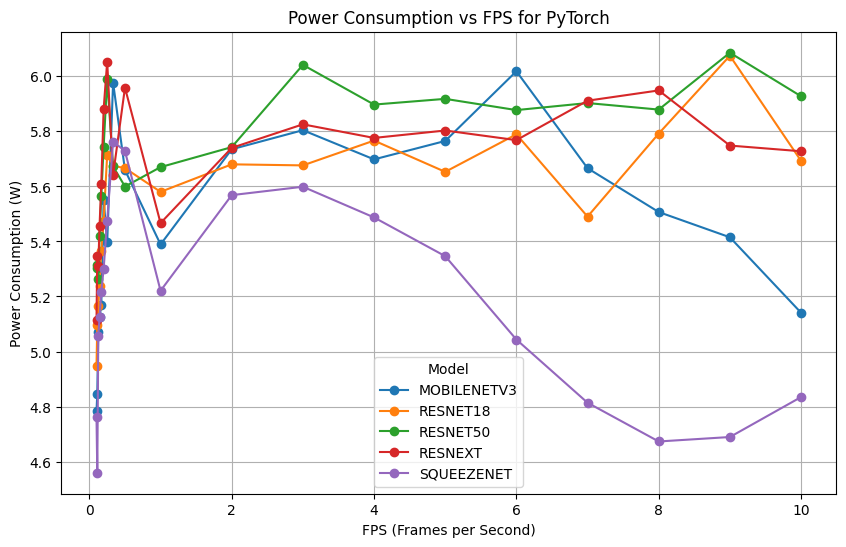

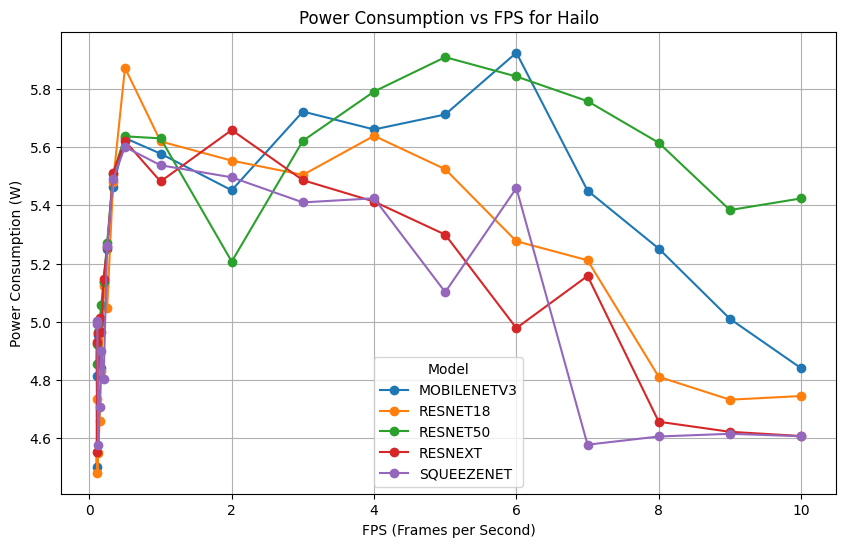

In [22]:
def plot_power_vs_fps(agg_data, framework_name):
    plt.figure(figsize=(10, 6))

    # Get the list of unique models
    models = agg_data['model'].unique()

    # Plot each model
    for model in models:
        model_data = agg_data[agg_data['model'] == model]
        plt.plot(model_data['fps'], model_data['mean_power'], marker='o', label=model)

    plt.xlabel('FPS (Frames per Second)')
    plt.ylabel('Power Consumption (W)')
    plt.title(f'Power Consumption vs FPS for {framework_name}')
    plt.legend(title='Model')
    plt.grid(True)
    plt.show()

# Plot for PyTorch framework
plot_power_vs_fps(pytorch_agg, 'PyTorch')

# Plot for Hailo framework
plot_power_vs_fps(hailo_agg, 'Hailo')

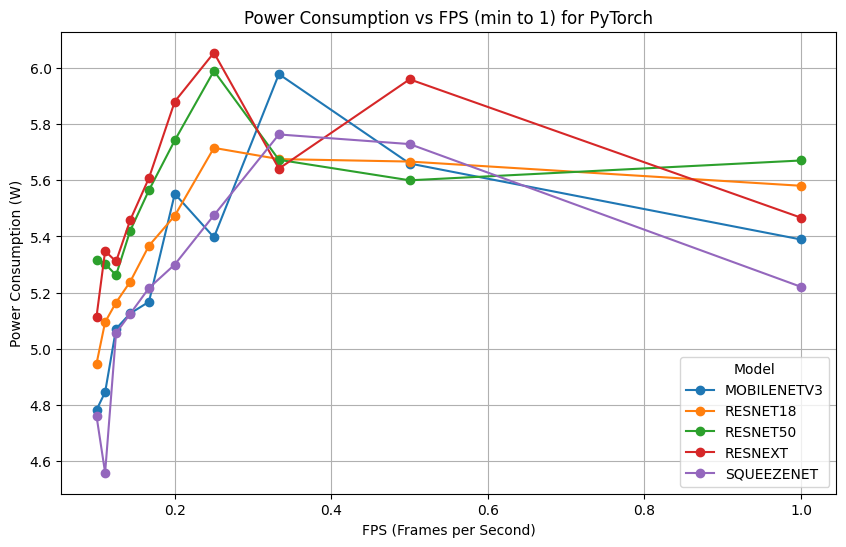

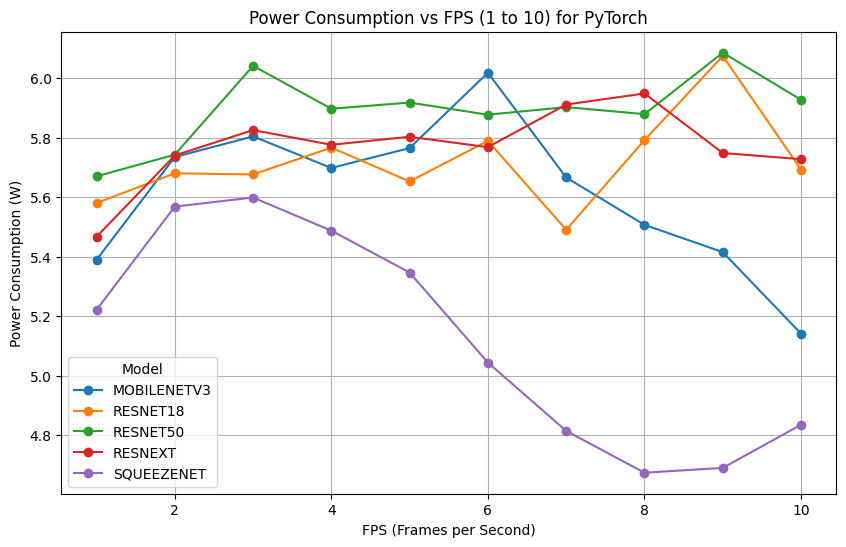

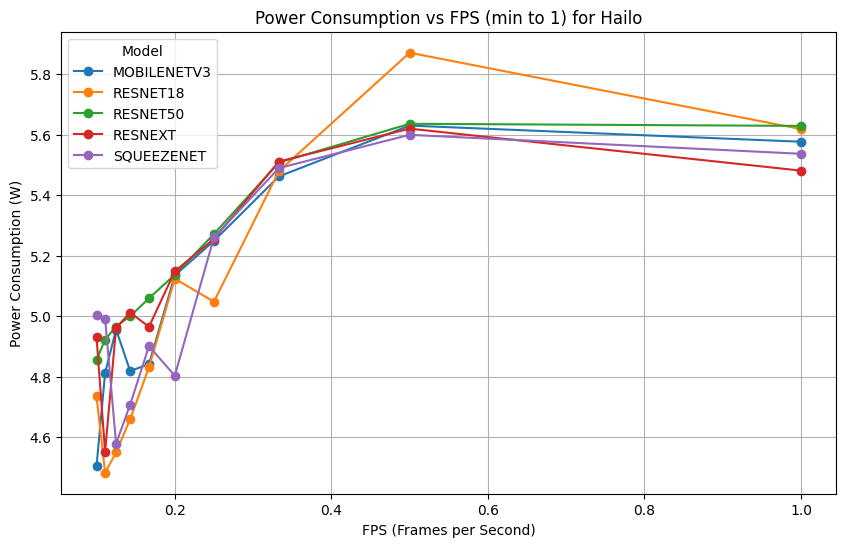

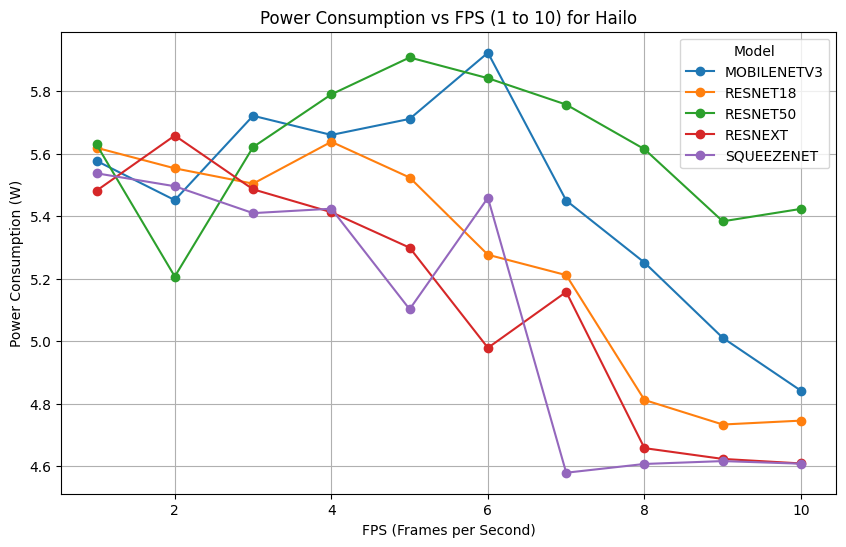

In [23]:
# Function to plot the graphs for a specific FPS range and framework
def plot_power_vs_fps(agg_data, framework_name, fps_range, plot_title):
    plt.figure(figsize=(10, 6))

    # Filter the data for the given FPS range
    filtered_data = agg_data[(agg_data['fps'] >= fps_range[0]) & (agg_data['fps'] <= fps_range[1])]

    # Get the list of unique models
    models = filtered_data['model'].unique()

    # Plot each model
    for model in models:
        model_data = filtered_data[filtered_data['model'] == model]
        plt.plot(model_data['fps'], model_data['mean_power'], marker='o', label=model)

    plt.xlabel('FPS (Frames per Second)')
    plt.ylabel('Power Consumption (W)')
    plt.title(plot_title)
    plt.legend(title='Model')
    plt.grid(True)
    plt.show()

# Define FPS ranges
fps_range_1 = (pytorch_agg['fps'].min(), 1)  # From min FPS to 1
fps_range_2 = (1, 10)  # From 1 to 10

# Plot for PyTorch, FPS range: min to 1
plot_power_vs_fps(pytorch_agg, 'PyTorch', fps_range_1, 'Power Consumption vs FPS (min to 1) for PyTorch')

# Plot for PyTorch, FPS range: 1 to 10
plot_power_vs_fps(pytorch_agg, 'PyTorch', fps_range_2, 'Power Consumption vs FPS (1 to 10) for PyTorch')

# Plot for Hailo, FPS range: min to 1
plot_power_vs_fps(hailo_agg, 'Hailo', fps_range_1, 'Power Consumption vs FPS (min to 1) for Hailo')

# Plot for Hailo, FPS range: 1 to 10
plot_power_vs_fps(hailo_agg, 'Hailo', fps_range_2, 'Power Consumption vs FPS (1 to 10) for Hailo')